In [1]:
%matplotlib inline


# Clustering players
In this tutorial we show how to cluster players to positions using their statistics. We will use a dataset provided by
Ronan Manning with statistics for everty top 5 leagues player, which is available [here](https://twitter.com/ronanmann/status/1408504415690969089?s=21).
This tutorial is inspired by John Muller's article on The Athletic [Introducing The Athletics 18 player roles](https://theathletic.com/3473297/2022/08/10/player-roles-the-athletic/).


In [2]:
#importing necessary libraries
import pandas as pd
import numpy as np
import warnings 
import matplotlib.pyplot as plt
from mplsoccer import Pitch
import os
import pathlib
import json

pd.options.mode.chained_assignment = None
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
np.random.seed(4)

## Preparing the dataset

We open the data and change minutes played to integers. Then, we keep ony players who played more than 500 minutes.
As the next step, we convert all data to numeric format and replace NaN with 0. Last but not least, 
we keep only columns
with player statistics.



In [13]:
#open data
data = pd.read_csv("data.csv")
#change minutes to numerics 
data["Min"] = data["Min"].apply(lambda x: x.replace(",", "")).astype(int)

data = data.loc[data["Min"] > 500]
data = data.reset_index(drop = True)
data = data.apply(pd.to_numeric, errors='coerce')
data = data.fillna(0)
X = data.iloc[:, 11:]

## Dimensionality reduction
Since we have over 100 features, it is important to reduce the dimensionality. First standard scaling 
is applied to data.
Then, we use UMAP algorithm, as in John Muller's article, to reduce the dimensions to 2. As the next step we plot
the data with formation label available in the dataset. 



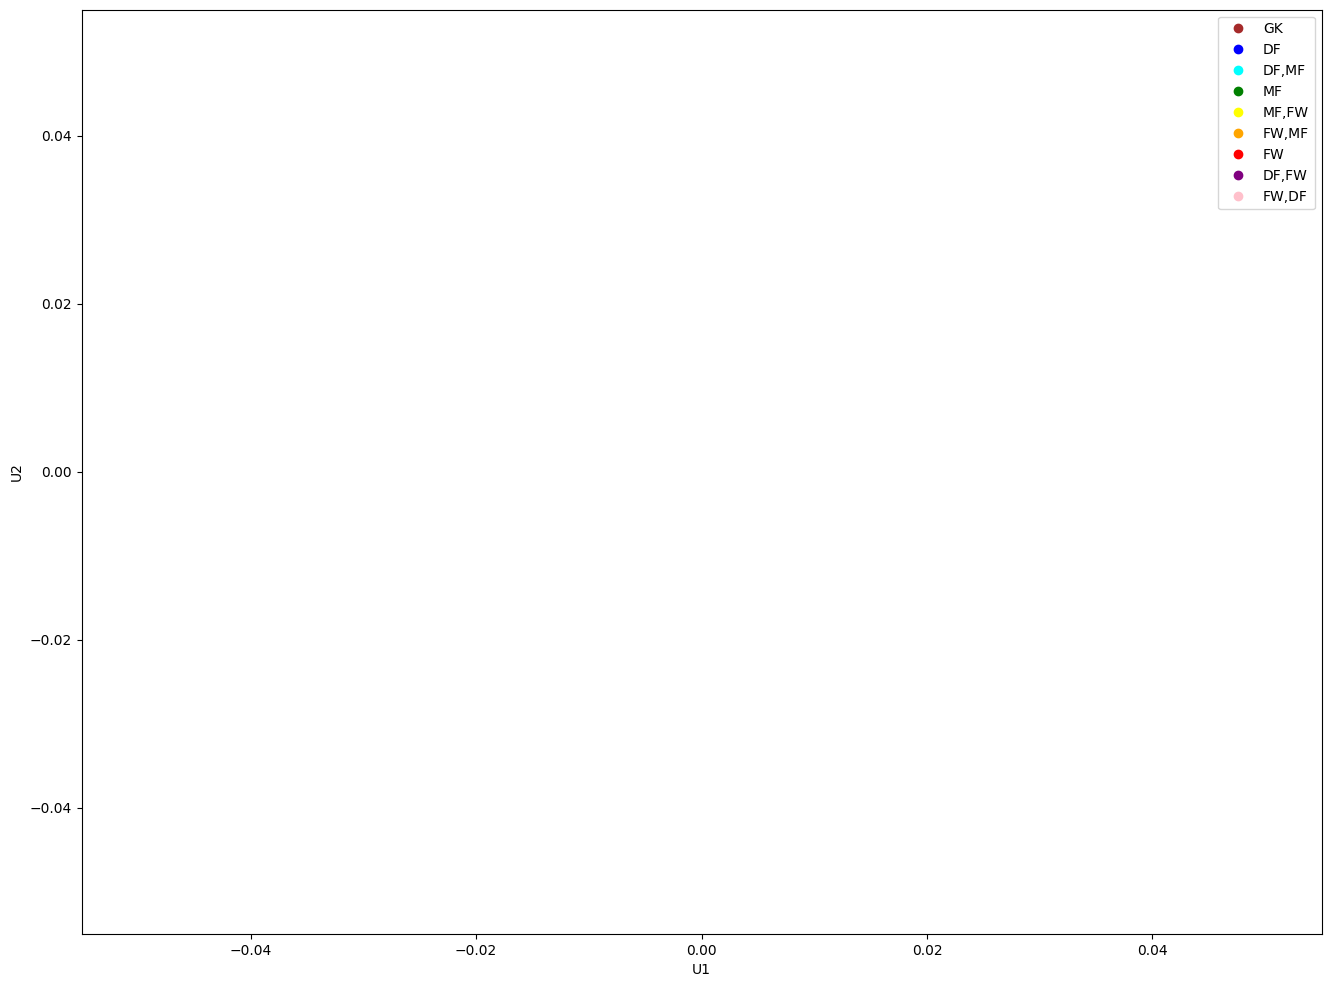

In [14]:
from umap import UMAP
from sklearn.preprocessing import StandardScaler
#scale data
scaler = StandardScaler()
X = scaler.fit_transform(X)
#dim reduction
reducer = UMAP(random_state = 2213)
comps = reducer.fit_transform(X)

#plotting
fig, ax = plt.subplots(figsize = (16,12))
#map position to color
colors = {"GK": "brown", "DF": "blue", "DF,MF": "aqua", "MF": "green", "MF,FW": "yellow", "FW,MF": "orange", "FW": "red", 'DF,FW': "purple", 'FW,DF': "pink"}
color_list = data.Pos.map(colors).to_list()

#plot it
for i in range(X.shape[0]):
    ax.scatter(comps[i,0], comps[i,1], c = color_list[i], s = 10)
ax.set_xlabel('U1')
ax.set_ylabel('U2')
#make legend
markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in colors.values()]
ax.legend(markers, colors.keys(), numpoints=1)
plt.show()

## Clustering
From the plot we claim that there are 6 clusters. We use hierarchical clustering (Ward method) to predict which
points belong to which cluster. Then, we plot the result of the clustering.



In [ ]:
from sklearn.cluster import AgglomerativeClustering
#declare object
scan = AgglomerativeClustering(n_clusters=6)
#make predictions
labels = scan.fit_predict(comps)
fig, ax = plt.subplots(figsize = (16,12))
ax.scatter(comps[:, 0], comps[:, 1], c=labels, s=10, cmap='gist_rainbow');
plt.show()

## Labelling clusters
To label the clusters, we saved predcitins together with player names. Looking for many characteristic players,
we label them in 6 formations - goalkeepers, centre-backs, full-backs, defensive midfielders, attacking midfielders
and strikers. 



In [ ]:
#explore the dataframe
see = data.iloc[:, 0:5]
see["label"] = labels
print(see.sample(frac = 1).head(10))

#plot predictions with a legend
fig, ax = plt.subplots(figsize = (16,12))
scatter = ax.scatter(comps[:, 0], comps[:, 1], c=labels, s=10, cmap='gist_rainbow');
handles = scatter.legend_elements()[0]
#order the labels for hierarchy
myorder = [3,0,1,2,4,5]
handles = [handles[i] for i in myorder]
#add legend
ax.legend(handles=handles, labels = ["GK", "CB", "FB", "DM", "AM", "ST"])
plt.show()

## A different approach to the same problem - dimensionality reduction
We can also approach this problem using different techniques. First, we reduce the dimensions using a pipeline of PCA
and tSNE. We also plot it the same way we did it for UMAP. 



In [ ]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.pipeline import Pipeline
#declare dim reduction objects
pca = PCA()
tsne = TSNE(random_state = 3454)
#declare pipeline
ts = Pipeline([    ('pca', pca),
    ('tsne', tsne)
])
#reduce dimensions
comps = ts.fit_transform(X)
#plot it
fig, ax = plt.subplots(figsize = (16,12))
for i in range(X.shape[0]):
    ax.scatter(comps[i,0], comps[i,1], c = color_list[i], s = 10)
ax.set_xlabel('t1')
ax.set_ylabel('t2')
markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in colors.values()]
ax.legend(markers, colors.keys(), numpoints=1)
plt.show()

## A different approach to the same problem - clustering
This time we cluster the data using Gaussian Mixture Model clustering. It is the same model as in Muller's article. 
We also plot the predictions on the 2 dimensional space. 



In [ ]:
from sklearn.mixture import GaussianMixture
#declare object
gmm = GaussianMixture(n_components=6, random_state=5).fit(comps)
#make predictions
labels = gmm.predict(comps)
fig, ax = plt.subplots(figsize = (16,12))
plt.scatter(comps[:, 0], comps[:, 1], c=labels, s=10, cmap='gist_rainbow');
plt.show()

## A different approach to the same problem - labelling
Here, we repeat steps we did previously to label the clusters. First, we investigate the dataframe with predictions,
then, we plot our clusters with labels.



In [ ]:
see = data.iloc[:, 0:5]
see["label"] = labels
print(see.sample(frac = 1).head(10))

#explore the dataframe
fig, ax = plt.subplots(figsize = (16,12))
scatter = ax.scatter(comps[:, 0], comps[:, 1], c=labels, s=10, cmap='gist_rainbow');
handles = scatter.legend_elements()[0]
#order the labels for hierarchy
myorder = [4,2,5,1,0,3]
handles = [handles[i] for i in myorder]
ax.legend(handles=handles, labels = ["GK", "CB", "FB", "DM", "AM", "ST"])
plt.show()